# 抓取 Dcard 資料

### 載入套件

In [ ]:
import pandas as pd
import requests
import re
from bs4 import BeautifulSoup

### 取得 Dcard 網頁內容

In [3]:
URL = 'https://www.dcard.tw/f'
resp = requests.get(URL)
soup = BeautifulSoup(resp.text, 'html.parser')
soup

<!DOCTYPE html>
<html lang="zh-Hant-TW"><head itemscope="" itemtype="https://schema.org/WebSite" prefix="og: http://ogp.me/ns#"><title data-react-helmet="true">全部 - Dcard</title><meta content="不想錯過任何有趣的話題嗎？趕快加入我們吧！" data-react-helmet="true" name="description"/><meta content="不想錯過任何有趣的話題嗎？趕快加入我們吧！" data-react-helmet="true" property="og:description"/><meta content="https://www.dcard.tw/build/landing-c9e7b8fb.png" data-react-helmet="true" property="og:image"/><meta content="https://www.dcard.tw/build/landing-c9e7b8fb.png" data-react-helmet="true" property="og:image:secure_url"/><meta charset="utf-8" data-react-helmet="true"/><meta content="IE=edge" data-react-helmet="true" http-equiv="X-UA-Compatible"/><meta content="Dcard" data-react-helmet="true" name="application-name"/><meta content="app-id=951353454" data-react-helmet="true" name="apple-itunes-app"/><meta content="#006aa6" data-react-helmet="true" name="theme-color"/><meta content="yes" data-react-helmet="true" name="mobile-web-app-c

### 找出熱門文章

In [4]:
articles = []
# 利用 regex 找出所有貼文
for item in soup.find_all('div', re.compile('PostList_entry')):
    articles.append({
        'title': item.h3.text,
        'excerpt': item.find_all('div', re.compile('PostEntry_(excerpt|reply)'))[0].text,
        'like_count': item.find_all('div', re.compile('PostEntry__LikeCount'))[0].text,
        'comments': re.findall(r'\d+', item.find_all('span', re.compile('PostEntry_comments'))[0].text)[0],
        'link': item.find_all('a', re.compile('PostEntry_root'))[0]['href']
    })

df = pd.DataFrame(articles, columns=['title', 'excerpt', 'like_count', 'comments', 'link'])  # 使用 columns 調整排列順序
print('共 %d 篇' % (len(df)))
df[:5] # 印出前 5 筆

共 30 篇


,title,excerpt,like_count,comments,link
0,幫高調！急！！！,昨天用機車載了我跟妹妹去上學之後，回家換了汽車不知道去哪裡，手機也沒帶，公司也打來家裡說他沒...,25825,258,/f/relationship/p/231283905-幫高調！急！！！
1,有人把韓國瑜海綿寶寶做出來,漫威要求創作韓國瑜的故事,8597,225,/f/trending/p/231286770-有人把韓國瑜海綿寶寶做出來
2,要怎麼陪爸爸考英文,上大學之後就很少回家了，就和大部分同學一樣，大概幾個禮拜回家那種，有時候回去，才發現父母的白...,6940,101,/f/exam/p/231285879-要怎麼陪爸爸考英文
3,會幫女友吹頭髮的男友最帥了,大多女生都不太愛吹頭髮，我也算在這之中，尤其是長頭髮真的要命，之前和前任在一起時，他是會幫我...,5811,209,/f/relationship/p/231283276-會幫女友吹頭髮的男友最帥了
4,如果中午打開便當長這樣....,腳丫也來一點好了～恩....嚇到吃腳腳，這是嘔吐物的概念ＸＤ，來源：只能說太有才啦，但拜託我...,4212,73,/f/food/p/231285581-如果中午打開便當長這樣....


# 使用 mLab 雲端資料庫

### 載入套件

In [43]:
import pandas as pd
import urllib.parse
import pymongo
from datetime import datetime
from pymongo import MongoClient
from bson.objectid import ObjectId

### 設置基本資料

In [8]:
host = 'ds263089.mlab.com'
port = '63089'
username = urllib.parse.quote_plus('fergus')
password = urllib.parse.quote_plus('abc123')
Authdb = 'dcard'

### 與資料庫連線

In [26]:
client = MongoClient('mongodb://%s:%s@%s:%s/%s?authMechanism=SCRAM-SHA-1'
                      % (username, password, host, port, Authdb))

db = client[Authdb]

### 創建 collection

In [27]:
collection_name = 'posts'
coll = db[collection_name]
# 查看是否連線成功
coll.stats

Collection(Database(MongoClient(host=['ds263089.mlab.com:63089'], document_class=dict, tz_aware=False, connect=True, authmechanism='SCRAM-SHA-1'), 'dcard'), 'posts.stats')

In [29]:
#取出所有doc
print(coll.find())

# 轉成list
print(list(coll.find()))

[]


### 插入單筆資料

In [49]:
dic = {
    'userid':'01',
    'username':'user1',
    'creattime':datetime.now(),
    'category': 'category1'
}

coll.insert_one(dic)
list(coll.find())  # 查看資料

[{'_id': ObjectId('5cdc269b3fc7f2c0c5786879'),
  'userid': '01',
  'username': 'user1',
  'creattime': datetime.datetime(2019, 5, 15, 22, 47, 55, 697000),
  'category': 'category1'}]

### 插入多筆資料

In [50]:
dic_list = [
    {
        'userid':'02',
        'username':'user2',
        'creattime':datetime.now(),
        'category': 'category1'
    },
    {
        'userid':'03',
        'username':'user3',
        'creattime':datetime.strptime('2019-05-01 18:26:42', '%Y-%m-%d %H:%M:%S'),
        'category': 'category1'
    },
    {
        'userid':'04',
        'username':'user4',
        'creattime':datetime.now(),
        'category': 'category2'
    },
    {
        'userid':'05',
        'username':'user5',
        'creattime':datetime.now(),
        'category': 'category2'
    },
]

coll.insert_many(dic_list)
list(coll.find())

[{'_id': ObjectId('5cdc269b3fc7f2c0c5786879'),
  'userid': '01',
  'username': 'user1',
  'creattime': datetime.datetime(2019, 5, 15, 22, 47, 55, 697000),
  'category': 'category1'},
 {'_id': ObjectId('5cdc269e3fc7f2c0c578687a'),
  'userid': '02',
  'username': 'user2',
  'creattime': datetime.datetime(2019, 5, 15, 22, 47, 58, 860000),
  'category': 'category1'},
 {'_id': ObjectId('5cdc269e3fc7f2c0c578687b'),
  'userid': '03',
  'username': 'user3',
  'creattime': datetime.datetime(2019, 5, 1, 18, 26, 42),
  'category': 'category1'},
 {'_id': ObjectId('5cdc269e3fc7f2c0c578687c'),
  'userid': '04',
  'username': 'user4',
  'creattime': datetime.datetime(2019, 5, 15, 22, 47, 58, 861000),
  'category': 'category2'},
 {'_id': ObjectId('5cdc269e3fc7f2c0c578687d'),
  'userid': '05',
  'username': 'user5',
  'creattime': datetime.datetime(2019, 5, 15, 22, 47, 58, 861000),
  'category': 'category2'}]

### 排序

In [23]:
# 預設遞增(ASCENDING)排序 A -> Z
list(coll.find().sort("username"))
# list(coll.find().sort("username",pymongo.ASCENDING))
# list(coll.find().sort("username",pymongo.DESCENDING))

[{'_id': ObjectId('5cdc180e3fc7f2c0c5786862'),
  'userid': '01',
  'username': 'user1',
  'creattime': datetime.datetime(2019, 5, 15, 21, 45, 50, 291000),
  'type': 'type1'},
 {'_id': ObjectId('5cdc18be3fc7f2c0c5786867'),
  'userid': '02',
  'username': 'user2',
  'creattime': datetime.datetime(2019, 5, 15, 21, 48, 46, 167000),
  'type': 'type1'},
 {'_id': ObjectId('5cdc18be3fc7f2c0c5786868'),
  'userid': '03',
  'username': 'user3',
  'creattime': datetime.datetime(2019, 5, 15, 21, 48, 46, 167000),
  'type': 'type1'},
 {'_id': ObjectId('5cdc18be3fc7f2c0c5786869'),
  'userid': '04',
  'username': 'user4',
  'creattime': datetime.datetime(2019, 5, 15, 21, 48, 46, 167000),
  'type': 'type2'},
 {'_id': ObjectId('5cdc18be3fc7f2c0c578686a'),
  'userid': '05',
  'username': 'user5',
  'creattime': datetime.datetime(2019, 5, 15, 21, 48, 46, 167000),
  'type': 'type5'}]

### 依時間區間選取

In [41]:
start = datetime.strptime('2019-05-01 00:00:00',
                           '%Y-%m-%d %H:%M:%S')
end = datetime.strptime('2019-05-01 23:59:59',
                           '%Y-%m-%d %H:%M:%S')
list(coll.find({'creattime': {'$gte': start, '$lt': end}}))

[{'_id': ObjectId('5cdc1f823fc7f2c0c5786876'),
  'userid': '03',
  'username': 'user3',
  'creattime': datetime.datetime(2019, 5, 1, 18, 26, 42),
  'category': 'category1'}]

### 依照 id 選取

In [44]:
list(coll.find({'_id':ObjectId('5cdc1e4c3fc7f2c0c5786870')}))

[{'_id': ObjectId('5cdc1e4c3fc7f2c0c5786870'),
  'userid': '01',
  'username': 'user1',
  'creattime': datetime.datetime(2019, 5, 15, 22, 12, 28, 104000),
  'category': 'category1'}]

### 更新資料(整個覆蓋)

In [51]:
coll.replace_one({'username':'user1'} ,
             {'username':'user6', 'category':'category3'})
list(coll.find())

[{'_id': ObjectId('5cdc269b3fc7f2c0c5786879'),
  'username': 'user6',
  'category': 'category3'},
 {'_id': ObjectId('5cdc269e3fc7f2c0c578687a'),
  'userid': '02',
  'username': 'user2',
  'creattime': datetime.datetime(2019, 5, 15, 22, 47, 58, 860000),
  'category': 'category1'},
 {'_id': ObjectId('5cdc269e3fc7f2c0c578687b'),
  'userid': '03',
  'username': 'user3',
  'creattime': datetime.datetime(2019, 5, 1, 18, 26, 42),
  'category': 'category1'},
 {'_id': ObjectId('5cdc269e3fc7f2c0c578687c'),
  'userid': '04',
  'username': 'user4',
  'creattime': datetime.datetime(2019, 5, 15, 22, 47, 58, 861000),
  'category': 'category2'},
 {'_id': ObjectId('5cdc269e3fc7f2c0c578687d'),
  'userid': '05',
  'username': 'user5',
  'creattime': datetime.datetime(2019, 5, 15, 22, 47, 58, 861000),
  'category': 'category2'}]

### 更新資料(修改元素)

In [52]:
coll.update_one({"username":"user2"},
            {"$set":{"category":"category4","comments": 123}})
list(coll.find())

[{'_id': ObjectId('5cdc269b3fc7f2c0c5786879'),
  'username': 'user6',
  'category': 'category3'},
 {'_id': ObjectId('5cdc269e3fc7f2c0c578687b'),
  'userid': '03',
  'username': 'user3',
  'creattime': datetime.datetime(2019, 5, 1, 18, 26, 42),
  'category': 'category1'},
 {'_id': ObjectId('5cdc269e3fc7f2c0c578687c'),
  'userid': '04',
  'username': 'user4',
  'creattime': datetime.datetime(2019, 5, 15, 22, 47, 58, 861000),
  'category': 'category2'},
 {'_id': ObjectId('5cdc269e3fc7f2c0c578687d'),
  'userid': '05',
  'username': 'user5',
  'creattime': datetime.datetime(2019, 5, 15, 22, 47, 58, 861000),
  'category': 'category2'},
 {'_id': ObjectId('5cdc269e3fc7f2c0c578687a'),
  'userid': '02',
  'username': 'user2',
  'creattime': datetime.datetime(2019, 5, 15, 22, 47, 58, 860000),
  'category': 'category4',
  'comments': 123}]

### 移除單筆資料

In [54]:
coll.delete_one({'username':'user6'})
list(coll.find())

[{'_id': ObjectId('5cdc269e3fc7f2c0c578687b'),
  'userid': '03',
  'username': 'user3',
  'creattime': datetime.datetime(2019, 5, 1, 18, 26, 42),
  'category': 'category1'},
 {'_id': ObjectId('5cdc269e3fc7f2c0c578687c'),
  'userid': '04',
  'username': 'user4',
  'creattime': datetime.datetime(2019, 5, 15, 22, 47, 58, 861000),
  'category': 'category2'},
 {'_id': ObjectId('5cdc269e3fc7f2c0c578687d'),
  'userid': '05',
  'username': 'user5',
  'creattime': datetime.datetime(2019, 5, 15, 22, 47, 58, 861000),
  'category': 'category2'},
 {'_id': ObjectId('5cdc269e3fc7f2c0c578687a'),
  'userid': '02',
  'username': 'user2',
  'creattime': datetime.datetime(2019, 5, 15, 22, 47, 58, 860000),
  'category': 'category4',
  'comments': 123}]

### 移除多筆資料

In [56]:
coll.delete_many({'category':'category2'})
list(coll.find())

[{'_id': ObjectId('5cdc269e3fc7f2c0c578687b'),
  'userid': '03',
  'username': 'user3',
  'creattime': datetime.datetime(2019, 5, 1, 18, 26, 42),
  'category': 'category1'},
 {'_id': ObjectId('5cdc269e3fc7f2c0c578687a'),
  'userid': '02',
  'username': 'user2',
  'creattime': datetime.datetime(2019, 5, 15, 22, 47, 58, 860000),
  'category': 'category4',
  'comments': 123}]

### 移除所有資料

In [57]:
coll.delete_many({})
list(coll.find())

[]

## 將 dcard 資料儲存到 mlab

In [ ]:
dic_list = articles
coll.insert_many(dic_list)

## dcard api

In [ ]:
# https://levirve.github.io/blog/2016/Dccard-crawler/
# http://blog.cgmlife.net/posts/2019/03/18/problems-i-met-when-using-the-dcard-api
# https://medium.com/pyladies-taiwan/%E7%88%AC%E8%9F%B2-%E5%BE%9Edcard%E7%B6%B2%E7%AB%99%E7%9C%8B%E7%88%AC%E8%9F%B2%E5%85%A5%E9%96%80-ii-91e2357b82c6


# https://www.cakeresume.com/
# https://www.yourator.co/
# https://meet.jobs/
# https://github.com/f2etw/jobs/issues
# https://www.qollie.com/

# 輕鬆學習 Python：使用 Flask 創建 Web API
# https://medium.com/datainpoint/flask-web-api-quickstart-3b13d96cccc2?sk=67e2f10ef576d0e3bdf80a79b922e4db


## 抓取 dcard api 文章

In [ ]:
# https://www.dcard.tw/_api/forums/buyonline/posts
# https://www.dcard.tw/_api/posts/231231568

## 自然語言處理

Building prefix dict from /Users/kejingtai/Desktop/python_workshop/test/dict.txt.big ...
Loading model from cache /var/folders/44/zp824dwd35xgspx7qbslc2740000gn/T/jieba.udbeef8de22742648faa9c592ef461f1e.cache
Loading model cost 1.207 seconds.
Prefix dict has been built succesfully.


['Python', '是', '非常', '強的', '的', '程式', '語言', ',', ' ', '簡潔', '友好', '的', '語法', '特別', '容易', '上', '手', ',', ' ', '又', '有', '許多', '第三方', '函式', '庫', '的', '支援', '。', ' ', 'Python', '是', '完全', '物件', '導向', '的', '語言', ',', ' ', '有益於', '減少', '程式碼', '的', '重複性', '。', 'Python', '的', '設計', '哲學', '是', '優雅', ',', ' ', '明確', ',', ' ', '簡單', '。', ' ', 'Python', '的', '設計', '風格', ',', ' ', '使', '其成', '為', '易讀', ',', ' ', '易', '維護', '且', '具有', '廣泛', '用途', '的', '程式', '語言', '。']
[('自己', 24), ('動次', 24), ('煩惱', 20), ('突然', 18), ('回憶', 12), ('地球', 12), ('甩掉', 12), ('噗通', 12), ('不要', 11), ('快樂', 11)]


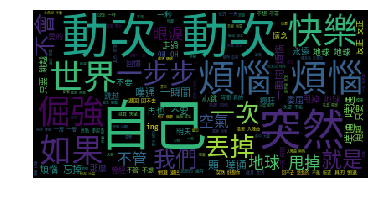

In [32]:
# jieba: https://github.com/fxsjy/jieba
# wordcloud: https://pypi.org/project/wordcloud/
# https://www.setn.com/News.aspx?NewsID=7512
# https://tw.pycon.org/2016/en-us/events/talk/27349121996161025/

import json
import jieba
import matplotlib.pyplot as plt
from collections import Counter
from wordcloud import WordCloud

jieba.set_dictionary('dict.txt.big')  # 對繁體中文斷詞較準確的字典檔

def jieba_test():
    s = 'Python是非常強的的程式語言, 簡潔友好的語法特別容易上手, 又有許多第三方函式庫的支援。 ' \
        'Python是完全物件導向的語言, 有益於減少程式碼的重複性。' \
        'Python的設計哲學是優雅, 明確, 簡單。 Python的設計風格, 使其成為易讀, 易維護且具有廣泛用途的程式語言。'
    print([seg for seg in jieba.cut(s)])


def lyrics():
    with open('lyrics.json', 'r', encoding='utf-8') as f:
        data = json.load(f)
    tokens = list()
    for v in data.values():
        # 斷詞後的結果, 若非空白且長度為 2 以上, 則列入詞庫
        tokens += [seg for seg in jieba.cut(v) if seg.split() and len(seg) > 1]

    # 計算 tokens 內各詞彙的出現次數
    counter = Counter(tokens)
    print(counter.most_common(10))

    # 文字雲, 要顯示中文需附上字型檔
    wcloud = WordCloud(font_path='NotoSansMonoCJKtc-Regular.otf').generate(' '.join(tokens))
    plt.imshow(wcloud)
    plt.axis('off')
    plt.show()


if __name__ == '__main__':
    jieba_test()
    lyrics()

## 使用 sqlite3 儲存資料
DB Browser for SQLite: 
[https://sqlitebrowser.org/](https://sqlitebrowser.org/)

In [118]:
import sqlite3
conn = sqlite3.connect('dcard.sqlite3')

# 存檔
# index: 設定是否加上索引
# if_exists='replace'，假如 sql 中已經有 daily_price 這個 dataframe，則直接覆蓋掉它
df.to_sql('posts', conn, index=True, if_exists='replace')

In [123]:
# 讀檔
# index_col: 讀取時，把某行當成索引
df_sqlite = pd.read_sql('select * from posts', conn, index_col=['index'])
df_sqlite.head()

,title,excerpt,like_count,comments,link
index,,,,,
0,千萬別嗆哲學系的學生,前幾天和某強者朋友坐自強號下中壢去，深深的體會到沒事千萬別惹上哲學系的學生，一大長串邏輯清楚...,30580,423,/f/talk/p/231201871-千萬別嗆哲學系的學生
1,8+9妹日常(快笑死)更新,無意間發現一個8+9妹的臉書，點進去看真的快笑死，原來她們的價值觀是如此特別啊～忽有龐然大物...,16634,877,/f/funny/p/231200030-8+9妹日常（快笑死）更新
2,USJ現任環球影城員工告訴你環球怎麼玩,安安大家好️，我目前在日本讀書，因為很愛很愛很愛環球 就跑來考他們的員工了，也很幸運被選上，...,9392,310,/f/travel/p/231201771-USJ現任環球影城員工告訴你環球怎麼玩
3,為什麼辛普森在中國被禁?,辛普森酸到沒極限,7384,208,/f/trending/p/231201526-為什麼辛普森在中國被禁？
4,從47級分到75級分的逐夢旅,更-關於毅力，我不是高中畢業後就一直想考醫學系的，大學畢業後在擔任交通替代役時，我遇到了一場...,3637,444,/f/exam/p/231204975-從47級分到75級分的逐夢旅


## 使用 csv 儲存資料

In [105]:
#定義網址
url = 'https://tw.buy.yahoo.com/category/28507312'

#向網址要回網頁原始碼，並透過 BeautifulSoup 解析
res = requests.get(url)
soup = BeautifulSoup(res.text, 'html.parser')

'''
透過 soup.find_all 找到網頁原始碼中所有 class = "item yui3-u srp-multi-image" 的資料，
並一個個透過 .stripped_strings 將其資訊拆開
'''
for asus in soup.find_all(class_='gridList')[0].find_all('li'):
    values = list(asus.stripped_strings)
    #不是補貨中的資料才印出
    if '補貨中' not in values:
        print(values)

['智慧型手機', '(844)']
['一般型手機', '(55)']
['平板電腦', '(1)']
['充電器', '(1)']
['手機皮套/手機殼', '(1)']
['行動週邊', '(4)']
['運動穿戴配件', '(1)']


In [112]:
a = soup.find_all(class_='gridList')[0].find_all(re.compile('BaseGridItem__itemInfo'))
a

<ul class="gridList StructureData__optionList___1pSU4" data-type="cluster"><li class="gridItem StructureData__option___3UZtD StructureData__optionCluster___112Ka"><button class="clusterI13nButton StructureData__clusterI13nButton___1OfXD" data-link="28507312?flc=%E6%99%BA%E6%85%A7%E5%9E%8B%E6%89%8B%E6%A9%9F"><span class="StructureData__buttonWrap___1oK3d"><span class="StructureData__optionText___3tzTZ textEllipsis">智慧型手機</span><span>(844)</span></span></button></li><li class="gridItem StructureData__option___3UZtD StructureData__optionCluster___112Ka"><button class="clusterI13nButton StructureData__clusterI13nButton___1OfXD" data-link="28507312?flc=%E4%B8%80%E8%88%AC%E5%9E%8B%E6%89%8B%E6%A9%9F"><span class="StructureData__buttonWrap___1oK3d"><span class="StructureData__optionText___3tzTZ textEllipsis">一般型手機</span><span>(55)</span></span></button></li><li class="gridItem StructureData__option___3UZtD StructureData__optionCluster___112Ka"><button class="clusterI13nButton StructureData__cl

In [110]:
list(a[0].stripped_strings)[1]

'(844)'

In [ ]:
# 設置 ChromeDriver
# https://digishot.keenchief.com/tw/7066615261/7066615261
# https://www.leocode.net/article/index/20.html
# https://blog.csdn.net/ywj_486/article/details/80940087
# https://www.jianshu.com/p/39716ea15d99